# Sparsity Exploration Bayesian Optimization (SEBO) Ax API 

This tutorial introduces the Sparsity Exploration Bayesian Optimization (SEBO) method and demonstrates how to utilize it using the Ax API. SEBO is designed to enhance Bayesian Optimization (BO) by taking the interpretability and simplicity of configurations into consideration. In essence, SEBO incorporates sparsity, modeled as the $L_0$ norm, as an additional objective in BO. By employing multi-objective optimization techniques such as Expected Hyper-Volume Improvement, SEBO enables the joint optimization of objectives while simultaneously incorporating feature-level sparsity. This allows users to efficiently explore different trade-offs between objectives and sparsity.


For a more detailed understanding of the SEBO algorithm, please refer to the following publication:

[1] [S. Liu, Q. Feng, D. Eriksson, B. Letham and E. Bakshy. Sparse Bayesian Optimization. International Conference on Artificial Intelligence and Statistics, 2023.](https://proceedings.mlr.press/v206/liu23b/liu23b.pdf)

By following this tutorial, you will learn how to leverage the SEBO method through the Ax API, empowering you to effectively balance objectives and sparsity in your optimization tasks. Let's get started!

In [1]:
import os

from ax import Data, Experiment, ParameterType, RangeParameter, SearchSpace
from ax.modelbridge.registry import Models
from ax.runners.synthetic import SyntheticRunner

import warnings
warnings.filterwarnings('ignore')

In [2]:
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [3]:
import torch


torch.manual_seed(12345)  # To always get the same Sobol points
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

# Demo of using Developer API

## Problem Setup 

In this simple experiment we use the Branin function embedded in a 10-dimensional space. Additional resources:
- To set up a custom metric for your problem, refer to the dedicated section of the Developer API tutorial: https://ax.dev/tutorials/gpei_hartmann_developer.html#8.-Defining-custom-metrics.
- To avoid needing to setup up custom metrics by Ax Service API: https://ax.dev/tutorials/gpei_hartmann_service.html.

In [4]:
import math 
import numpy as np


aug_dim = 8 

# evaluation function 
def branin_augment(x_vec, augment_dim):
    assert len(x_vec) == augment_dim
    x1, x2 = (
        15 * x_vec[0] - 5,
        15 * x_vec[1],
    )  # Only dimensions 0 and augment_dim-1 affect the value of the function
    t1 = x2 - 5.1 / (4 * math.pi**2) * x1**2 + 5 / math.pi * x1 - 6
    t2 = 10 * (1 - 1 / (8 * math.pi)) * np.cos(x1)
    return t1**2 + t2 + 10

In [5]:
from ax.core.objective import Objective
from ax.core.optimization_config import OptimizationConfig
from ax.metrics.noisy_function import NoisyFunctionMetric
from ax.utils.common.typeutils import checked_cast


class AugBraninMetric(NoisyFunctionMetric):
    def f(self, x: np.ndarray) -> float:
        return checked_cast(float, branin_augment(x_vec=x, augment_dim=aug_dim))


# Create search space in Ax 
search_space = SearchSpace(
    parameters=[
        RangeParameter(
            name=f"x{i}",
            parameter_type=ParameterType.FLOAT, 
            lower=0.0, upper=1.0
        )
        for i in range(aug_dim)
    ]
)

In [6]:
# Create optimization goals 
optimization_config = OptimizationConfig(
    objective=Objective(
        metric=AugBraninMetric(
            name="objective",
            param_names=[f"x{i}" for i in range(aug_dim)],
            noise_sd=None,  # Set noise_sd=None if you want to learn the noise, otherwise it defaults to 1e-6
        ),
        minimize=True,
    )
)

# Experiment
experiment = Experiment(
    name="sebo_experiment",
    search_space=search_space,
    optimization_config=optimization_config,
    runner=SyntheticRunner(),
)

# target sparse point to regularize towards to. Here we set target sparse value being zero for all the parameters. 
target_point = torch.tensor([0 for _ in range(aug_dim)], **tkwargs)

## Run optimization loop

In [7]:
import torch 
from ax.models.torch.botorch_modular.surrogate import Surrogate
from botorch.models import SingleTaskGP, FixedNoiseGP, SaasFullyBayesianSingleTaskGP
from ax.models.torch.botorch_modular.sebo import SEBOAcquisition
from botorch.acquisition.multi_objective import qNoisyExpectedHypervolumeImprovement

In [8]:
N_INIT = 10
BATCH_SIZE = 1

if SMOKE_TEST:
    N_BATCHES = 1
    SURROGATE_CLASS = SingleTaskGP
else:
    N_BATCHES = 40
    SURROGATE_CLASS = SaasFullyBayesianSingleTaskGP

print(f"Doing {N_INIT + N_BATCHES * BATCH_SIZE} evaluations")

Doing 50 evaluations


In [9]:
# Initial Sobol points
sobol = Models.SOBOL(search_space=experiment.search_space)
for _ in range(N_INIT):
    experiment.new_trial(sobol.gen(1)).run()

In [10]:
data = experiment.fetch_data()

for i in range(N_BATCHES):

    model = Models.BOTORCH_MODULAR(
        experiment=experiment, 
        data=data,
        surrogate=Surrogate(botorch_model_class=SURROGATE_CLASS),  # can use SAASGP (i.e. SaasFullyBayesianSingleTaskGP) for high-dim cases
        search_space=experiment.search_space,
        botorch_acqf_class=qNoisyExpectedHypervolumeImprovement,
        acquisition_class=SEBOAcquisition,
        acquisition_options={
            "penalty": "L0_norm", # it can be L0_norm or L1_norm. 
            "target_point": target_point, 
            "sparsity_threshold": aug_dim,
        },
        torch_device=tkwargs['device'],
    )

    generator_run = model.gen(BATCH_SIZE)
    trial = experiment.new_batch_trial(generator_run=generator_run)
    trial.run()

    new_data = trial.fetch_data(metrics=list(experiment.metrics.values()))
    data = Data.from_multiple_data([data, new_data])
    print(f"Iteration: {i}, Best so far: {data.df['mean'].min():.3f}")

Iteration: 0, Best so far: 2.494


Iteration: 1, Best so far: 2.494


Iteration: 2, Best so far: 2.494


Iteration: 3, Best so far: 2.494


Iteration: 4, Best so far: 2.494


Iteration: 5, Best so far: 2.494


Iteration: 6, Best so far: 2.494


Iteration: 7, Best so far: 2.494


Iteration: 8, Best so far: 2.494


Iteration: 9, Best so far: 2.494


Iteration: 10, Best so far: 2.494


Iteration: 11, Best so far: 2.494


Iteration: 12, Best so far: 1.952


Iteration: 13, Best so far: 1.952


Iteration: 14, Best so far: 1.952


Iteration: 15, Best so far: 1.952


Iteration: 16, Best so far: 0.585


Iteration: 17, Best so far: 0.585


Iteration: 18, Best so far: 0.585


Iteration: 19, Best so far: 0.585


Iteration: 20, Best so far: 0.529


Iteration: 21, Best so far: 0.529


Iteration: 22, Best so far: 0.529


Iteration: 23, Best so far: 0.462


Iteration: 24, Best so far: 0.462


Iteration: 25, Best so far: 0.462


Iteration: 26, Best so far: 0.413


Iteration: 27, Best so far: 0.413


Iteration: 28, Best so far: 0.413


Iteration: 29, Best so far: 0.413


Iteration: 30, Best so far: 0.413


Iteration: 31, Best so far: 0.413


Iteration: 32, Best so far: 0.413


Iteration: 33, Best so far: 0.413


Iteration: 34, Best so far: 0.413


Iteration: 35, Best so far: 0.399


Iteration: 36, Best so far: 0.399


Iteration: 37, Best so far: 0.399


Iteration: 38, Best so far: 0.399


Iteration: 39, Best so far: 0.399


## Plot sparisty vs objective 

Visualize the objective and sparsity trade-offs using SEBO. Each point represent designs along the Pareto frontier found by SEBO. The x-axis corresponds to the number of active parameters used, i.e.
non-sparse parameters, and the y-axis corresponds the best identified objective values. Based on this, decision-makers balance both simplicity/interpretability of generated policies and optimization performance when deciding which configuration to use.

In [11]:
def nnz_exact(x, sparse_point):
    return len(x) - (np.array(x) == np.array(sparse_point)).sum()

    
df = data.df
df['L0_norm'] = df['arm_name'].apply(lambda d: nnz_exact(list(experiment.arms_by_name[d].parameters.values()), [0 for _ in range(aug_dim)]) )

In [12]:
result_by_sparsity = {l: df[df.L0_norm <= l]['mean'].min() for l in range(1, aug_dim+1)}
result_by_sparsity

{1: 5.052995681656048,
 2: 0.5291466924558517,
 3: 0.3987103544981654,
 4: 0.3987103544981654,
 5: 0.3987103544981654,
 6: 0.3987103544981654,
 7: 0.3987103544981654,
 8: 0.3987103544981654}

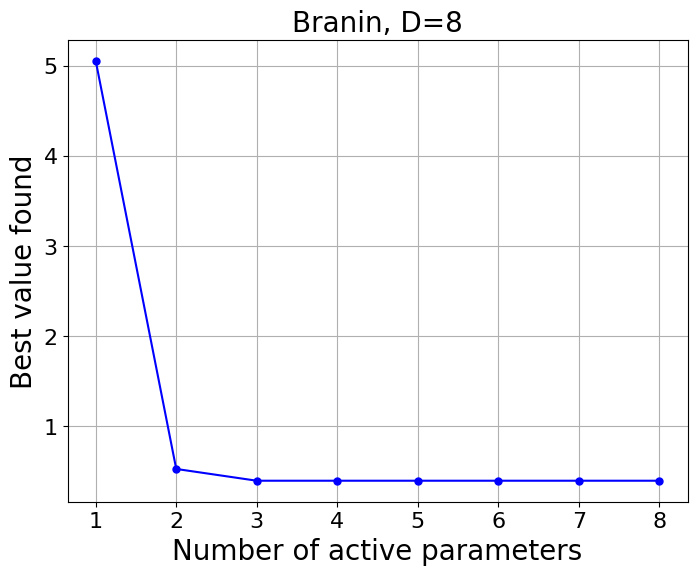

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
matplotlib.rcParams.update({"font.size": 16})

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(list(result_by_sparsity.keys()), list(result_by_sparsity.values()), '.b-', label="sebo", markersize=10)
ax.grid(True)
ax.set_title(f"Branin, D={aug_dim}", fontsize=20)
ax.set_xlabel("Number of active parameters", fontsize=20)
ax.set_ylabel("Best value found", fontsize=20)
# ax.legend(fontsize=18)
plt.show()

# Demo of Using GenerationStrategy and Service API 

Please check [Service API tutorial](https://ax.dev/tutorials/gpei_hartmann_service.html) for more detailed information. 

In [14]:
from ax.service.ax_client import AxClient, ObjectiveProperties

from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep

In [15]:
N_INIT = 10
BATCH_SIZE = 1

if SMOKE_TEST:
    NUM_TRIALS = 1
    SURROGATE_CLASS = FixedNoiseGP
else:
    NUM_TRIALS = 40
    SURROGATE_CLASS = SaasFullyBayesianSingleTaskGP

print(f"Doing {N_INIT + NUM_TRIALS * BATCH_SIZE} evaluations")

Doing 50 evaluations


## Create `GenerationStrategy`

In [16]:
gs = GenerationStrategy(
    name="SEBO_L0",
    steps=[
        GenerationStep(  # Initialization step
            model=Models.SOBOL,     
            num_trials=N_INIT,
        ),
        GenerationStep(  # BayesOpt step
            model=Models.BOTORCH_MODULAR,
            # No limit on how many generator runs will be produced
            num_trials=-1,
            model_kwargs={  # Kwargs to pass to `BoTorchModel.__init__`
                "surrogate": Surrogate(botorch_model_class=SURROGATE_CLASS),
                "acquisition_class": SEBOAcquisition,
                "botorch_acqf_class": qNoisyExpectedHypervolumeImprovement,
                "acquisition_options": {
                    "penalty": "L0_norm", # it can be L0_norm or L1_norm.
                    "target_point": target_point, 
                    "sparsity_threshold": aug_dim,
                },
            },
        )
    ]
)

## Initialize client and set up experiment

In [17]:
ax_client = AxClient(generation_strategy=gs)

experiment_parameters = [
    {
        "name": f"x{i}",
        "type": "range",
        "bounds": [0, 1],
        "value_type": "float",
        "log_scale": False,
    }
    for i in range(aug_dim)
]

objective_metrics = {
    "objective": ObjectiveProperties(minimize=False, threshold=-10),
}

ax_client.create_experiment(
    name="branin_augment_sebo_experiment",
    parameters=experiment_parameters,
    objectives=objective_metrics,
)

[INFO 08-11 14:51:29] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.


[INFO 08-11 14:51:29] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='x0', parameter_type=FLOAT, range=[0.0, 1.0]), RangeParameter(name='x1', parameter_type=FLOAT, range=[0.0, 1.0]), RangeParameter(name='x2', parameter_type=FLOAT, range=[0.0, 1.0]), RangeParameter(name='x3', parameter_type=FLOAT, range=[0.0, 1.0]), RangeParameter(name='x4', parameter_type=FLOAT, range=[0.0, 1.0]), RangeParameter(name='x5', parameter_type=FLOAT, range=[0.0, 1.0]), RangeParameter(name='x6', parameter_type=FLOAT, range=[0.0, 1.0]), RangeParameter(name='x7', parameter_type=FLOAT, range=[0.0, 1.0])], parameter_constraints=[]).


## Define evaluation function 

In [18]:
def evaluation(parameters):
    # put parameters into 1-D array
    x = [parameters.get(param["name"]) for param in experiment_parameters]
    res = branin_augment(x_vec=x, augment_dim=aug_dim)
    eval_res = {
        # flip the sign to maximize
        "objective": (res * -1, 0.0),
    }
    return eval_res

## Run optimization loop

In [19]:
for _ in range(NUM_TRIALS+N_INIT):    
    parameters, trial_index = ax_client.get_next_trial()
    res = evaluation(parameters)
    ax_client.complete_trial(trial_index=trial_index, raw_data=res)

[INFO 08-11 14:51:29] ax.service.ax_client: Generated new trial 0 with parameters {'x0': 0.704883, 'x1': 0.205139, 'x2': 0.222438, 'x3': 0.770468, 'x4': 0.154952, 'x5': 0.811032, 'x6': 0.742627, 'x7': 0.291557}.


[INFO 08-11 14:51:29] ax.service.ax_client: Completed trial 0 with data: {'objective': (-21.024841, 0.0)}.


[INFO 08-11 14:51:29] ax.service.ax_client: Generated new trial 1 with parameters {'x0': 0.30206, 'x1': 0.271992, 'x2': 0.586066, 'x3': 0.42023, 'x4': 0.069196, 'x5': 0.557135, 'x6': 0.404222, 'x7': 0.69039}.


[INFO 08-11 14:51:29] ax.service.ax_client: Completed trial 1 with data: {'objective': (-25.828685, 0.0)}.


[INFO 08-11 14:51:29] ax.service.ax_client: Generated new trial 2 with parameters {'x0': 0.358332, 'x1': 0.859848, 'x2': 0.056219, 'x3': 0.955052, 'x4': 0.226942, 'x5': 0.141809, 'x6': 0.252221, 'x7': 0.88703}.


[INFO 08-11 14:51:29] ax.service.ax_client: Completed trial 2 with data: {'objective': (-74.830737, 0.0)}.


[INFO 08-11 14:51:29] ax.service.ax_client: Generated new trial 3 with parameters {'x0': 0.243285, 'x1': 0.541794, 'x2': 0.179266, 'x3': 0.30948, 'x4': 0.598481, 'x5': 0.510642, 'x6': 0.783757, 'x7': 0.787818}.


[INFO 08-11 14:51:29] ax.service.ax_client: Completed trial 3 with data: {'objective': (-12.162956, 0.0)}.


[INFO 08-11 14:51:29] ax.service.ax_client: Generated new trial 4 with parameters {'x0': 0.939014, 'x1': 0.083082, 'x2': 0.206114, 'x3': 0.781272, 'x4': 0.188624, 'x5': 0.130669, 'x6': 0.592591, 'x7': 0.473514}.


[INFO 08-11 14:51:29] ax.service.ax_client: Completed trial 4 with data: {'objective': (-1.862493, 0.0)}.


[INFO 08-11 14:51:29] ax.service.ax_client: Generated new trial 5 with parameters {'x0': 0.205064, 'x1': 0.616438, 'x2': 0.897563, 'x3': 0.28032, 'x4': 0.471537, 'x5': 0.31668, 'x6': 0.907842, 'x7': 0.078156}.


[INFO 08-11 14:51:29] ax.service.ax_client: Completed trial 5 with data: {'objective': (-6.764524, 0.0)}.


[INFO 08-11 14:51:29] ax.service.ax_client: Generated new trial 6 with parameters {'x0': 0.438927, 'x1': 0.395098, 'x2': 0.820474, 'x3': 0.999315, 'x4': 0.430435, 'x5': 0.485137, 'x6': 0.388609, 'x7': 0.157998}.


[INFO 08-11 14:51:29] ax.service.ax_client: Completed trial 6 with data: {'objective': (-14.38228, 0.0)}.


[INFO 08-11 14:51:29] ax.service.ax_client: Generated new trial 7 with parameters {'x0': 0.753854, 'x1': 0.395782, 'x2': 0.091211, 'x3': 0.00595, 'x4': 0.627023, 'x5': 0.696988, 'x6': 0.457529, 'x7': 0.158159}.


[INFO 08-11 14:51:29] ax.service.ax_client: Completed trial 7 with data: {'objective': (-42.984787, 0.0)}.


[INFO 08-11 14:51:29] ax.service.ax_client: Generated new trial 8 with parameters {'x0': 0.464185, 'x1': 0.657506, 'x2': 0.761901, 'x3': 0.988556, 'x4': 0.526658, 'x5': 0.751462, 'x6': 0.810781, 'x7': 0.985123}.


[INFO 08-11 14:51:29] ax.service.ax_client: Completed trial 8 with data: {'objective': (-48.435898, 0.0)}.


[INFO 08-11 14:51:29] ax.service.ax_client: Generated new trial 9 with parameters {'x0': 0.358249, 'x1': 0.033648, 'x2': 0.37198, 'x3': 0.012237, 'x4': 0.247182, 'x5': 0.980918, 'x6': 0.548523, 'x7': 0.593622}.


[INFO 08-11 14:51:29] ax.service.ax_client: Completed trial 9 with data: {'objective': (-43.131037, 0.0)}.


[INFO 08-11 14:52:09] ax.service.ax_client: Generated new trial 10 with parameters {'x0': 0.0, 'x1': 0.0, 'x2': 0.0, 'x3': 0.872158, 'x4': 0.0, 'x5': 0.0, 'x6': 1.0, 'x7': 0.0}.


[INFO 08-11 14:52:09] ax.service.ax_client: Completed trial 10 with data: {'objective': (-308.129096, 0.0)}.


[INFO 08-11 14:53:06] ax.service.ax_client: Generated new trial 11 with parameters {'x0': 1.0, 'x1': 0.0, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 14:53:06] ax.service.ax_client: Completed trial 11 with data: {'objective': (-10.960889, 0.0)}.


[INFO 08-11 14:53:54] ax.service.ax_client: Generated new trial 12 with parameters {'x0': 1.0, 'x1': 0.0, 'x2': 1.0, 'x3': 0.664719, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 14:53:54] ax.service.ax_client: Completed trial 12 with data: {'objective': (-10.960889, 0.0)}.


[INFO 08-11 14:54:49] ax.service.ax_client: Generated new trial 13 with parameters {'x0': 0.0, 'x1': 1.0, 'x2': 1.0, 'x3': 0.0, 'x4': 1.0, 'x5': 0.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 14:54:49] ax.service.ax_client: Completed trial 13 with data: {'objective': (-17.5083, 0.0)}.


[INFO 08-11 14:55:51] ax.service.ax_client: Generated new trial 14 with parameters {'x0': 1.0, 'x1': 1.0, 'x2': 1.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 14:55:51] ax.service.ax_client: Completed trial 14 with data: {'objective': (-145.872191, 0.0)}.


[INFO 08-11 14:56:41] ax.service.ax_client: Generated new trial 15 with parameters {'x0': 0.866847, 'x1': 0.0, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0, 'x7': 1.0}.


[INFO 08-11 14:56:41] ax.service.ax_client: Completed trial 15 with data: {'objective': (-10.938652, 0.0)}.


[INFO 08-11 14:57:37] ax.service.ax_client: Generated new trial 16 with parameters {'x0': 1.0, 'x1': 0.0, 'x2': 0.0, 'x3': 1.0, 'x4': 0.0, 'x5': 1.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 14:57:37] ax.service.ax_client: Completed trial 16 with data: {'objective': (-10.960889, 0.0)}.


[INFO 08-11 14:58:37] ax.service.ax_client: Generated new trial 17 with parameters {'x0': 1.0, 'x1': 0.0, 'x2': 0.0, 'x3': 1.0, 'x4': 1.0, 'x5': 0.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 14:58:37] ax.service.ax_client: Completed trial 17 with data: {'objective': (-10.960889, 0.0)}.


[INFO 08-11 14:59:33] ax.service.ax_client: Generated new trial 18 with parameters {'x0': 1.0, 'x1': 0.0, 'x2': 1.0, 'x3': 0.0, 'x4': 1.0, 'x5': 0.0, 'x6': 1.0, 'x7': 0.0}.


[INFO 08-11 14:59:33] ax.service.ax_client: Completed trial 18 with data: {'objective': (-10.960889, 0.0)}.


[INFO 08-11 15:00:28] ax.service.ax_client: Generated new trial 19 with parameters {'x0': 0.262518, 'x1': 0.586209, 'x2': 1.0, 'x3': 0.0, 'x4': 1.0, 'x5': 1.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 15:00:28] ax.service.ax_client: Completed trial 19 with data: {'objective': (-15.590937, 0.0)}.


[INFO 08-11 15:01:29] ax.service.ax_client: Generated new trial 20 with parameters {'x0': 0.917558, 'x1': 0.0, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.0, 'x6': 1.0, 'x7': 0.0}.


[INFO 08-11 15:01:29] ax.service.ax_client: Completed trial 20 with data: {'objective': (-6.317813, 0.0)}.


[INFO 08-11 15:02:28] ax.service.ax_client: Generated new trial 21 with parameters {'x0': 0.571964, 'x1': 0.0, 'x2': 1.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 15:02:28] ax.service.ax_client: Completed trial 21 with data: {'objective': (-5.138674, 0.0)}.


[INFO 08-11 15:03:46] ax.service.ax_client: Generated new trial 22 with parameters {'x0': 0.108097, 'x1': 1.0, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 15:03:46] ax.service.ax_client: Completed trial 22 with data: {'objective': (-5.281381, 0.0)}.


[INFO 08-11 15:04:50] ax.service.ax_client: Generated new trial 23 with parameters {'x0': 0.11245, 'x1': 0.816809, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 15:04:50] ax.service.ax_client: Completed trial 23 with data: {'objective': (-0.731882, 0.0)}.


[INFO 08-11 15:05:55] ax.service.ax_client: Generated new trial 24 with parameters {'x0': 0.113096, 'x1': 0.868415, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.0, 'x6': 1.0, 'x7': 0.0}.


[INFO 08-11 15:05:55] ax.service.ax_client: Completed trial 24 with data: {'objective': (-0.652149, 0.0)}.


[INFO 08-11 15:06:59] ax.service.ax_client: Generated new trial 25 with parameters {'x0': 0.0, 'x1': 1.0, 'x2': 1.0, 'x3': 0.0, 'x4': 0.0, 'x5': 1.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 15:06:59] ax.service.ax_client: Completed trial 25 with data: {'objective': (-17.5083, 0.0)}.


[INFO 08-11 15:08:02] ax.service.ax_client: Generated new trial 26 with parameters {'x0': 0.530208, 'x1': 0.167215, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 15:08:02] ax.service.ax_client: Completed trial 26 with data: {'objective': (-0.574587, 0.0)}.


[INFO 08-11 15:09:03] ax.service.ax_client: Generated new trial 27 with parameters {'x0': 0.136699, 'x1': 0.81113, 'x2': 1.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0, 'x7': 1.0}.


[INFO 08-11 15:09:03] ax.service.ax_client: Completed trial 27 with data: {'objective': (-0.696147, 0.0)}.


[INFO 08-11 15:09:57] ax.service.ax_client: Generated new trial 28 with parameters {'x0': 1.0, 'x1': 0.244575, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 15:09:57] ax.service.ax_client: Completed trial 28 with data: {'objective': (-2.386257, 0.0)}.


[INFO 08-11 15:10:53] ax.service.ax_client: Generated new trial 29 with parameters {'x0': 0.953153, 'x1': 0.177357, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 15:10:53] ax.service.ax_client: Completed trial 29 with data: {'objective': (-0.560355, 0.0)}.


[INFO 08-11 15:11:49] ax.service.ax_client: Generated new trial 30 with parameters {'x0': 0.517749, 'x1': 0.122568, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 1.0, 'x6': 1.0, 'x7': 0.0}.


[INFO 08-11 15:11:49] ax.service.ax_client: Completed trial 30 with data: {'objective': (-1.625041, 0.0)}.


[INFO 08-11 15:12:42] ax.service.ax_client: Generated new trial 31 with parameters {'x0': 0.132413, 'x1': 0.808022, 'x2': 0.0, 'x3': 1.0, 'x4': 0.0, 'x5': 1.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 15:12:42] ax.service.ax_client: Completed trial 31 with data: {'objective': (-0.498764, 0.0)}.


[INFO 08-11 15:13:51] ax.service.ax_client: Generated new trial 32 with parameters {'x0': 0.564403, 'x1': 0.147338, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 15:13:51] ax.service.ax_client: Completed trial 32 with data: {'objective': (-0.929324, 0.0)}.


[INFO 08-11 15:15:18] ax.service.ax_client: Generated new trial 33 with parameters {'x0': 0.972392, 'x1': 0.165374, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0, 'x7': 1.0}.


[INFO 08-11 15:15:18] ax.service.ax_client: Completed trial 33 with data: {'objective': (-0.540079, 0.0)}.


[INFO 08-11 15:16:52] ax.service.ax_client: Generated new trial 34 with parameters {'x0': 0.5422, 'x1': 0.146529, 'x2': 1.0, 'x3': 1.0, 'x4': 1.0, 'x5': 0.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 15:16:52] ax.service.ax_client: Completed trial 34 with data: {'objective': (-0.405259, 0.0)}.


[INFO 08-11 15:18:26] ax.service.ax_client: Generated new trial 35 with parameters {'x0': 0.967729, 'x1': 0.169491, 'x2': 0.0, 'x3': 1.0, 'x4': 0.0, 'x5': 0.0, 'x6': 1.0, 'x7': 0.0}.


[INFO 08-11 15:18:26] ax.service.ax_client: Completed trial 35 with data: {'objective': (-0.437863, 0.0)}.


[INFO 08-11 15:20:25] ax.service.ax_client: Generated new trial 36 with parameters {'x0': 0.543487, 'x1': 0.171605, 'x2': 1.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.0, 'x6': 1.0, 'x7': 0.0}.


[INFO 08-11 15:20:25] ax.service.ax_client: Completed trial 36 with data: {'objective': (-0.492944, 0.0)}.


[INFO 08-11 15:21:52] ax.service.ax_client: Generated new trial 37 with parameters {'x0': 0.543938, 'x1': 0.138065, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0, 'x7': 1.0}.


[INFO 08-11 15:21:52] ax.service.ax_client: Completed trial 37 with data: {'objective': (-0.435617, 0.0)}.


[INFO 08-11 15:23:27] ax.service.ax_client: Generated new trial 38 with parameters {'x0': 0.105987, 'x1': 0.864337, 'x2': 0.0, 'x3': 1.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0, 'x7': 1.0}.


[INFO 08-11 15:23:27] ax.service.ax_client: Completed trial 38 with data: {'objective': (-0.743448, 0.0)}.


[INFO 08-11 15:25:15] ax.service.ax_client: Generated new trial 39 with parameters {'x0': 0.129307, 'x1': 0.804259, 'x2': 0.0, 'x3': 0.0, 'x4': 1.0, 'x5': 0.0, 'x6': 1.0, 'x7': 1.0}.


[INFO 08-11 15:25:15] ax.service.ax_client: Completed trial 39 with data: {'objective': (-0.42981, 0.0)}.


[INFO 08-11 15:26:57] ax.service.ax_client: Generated new trial 40 with parameters {'x0': 0.965445, 'x1': 0.160704, 'x2': 1.0, 'x3': 0.0, 'x4': 0.0, 'x5': 1.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 15:26:57] ax.service.ax_client: Completed trial 40 with data: {'objective': (-0.426163, 0.0)}.


[INFO 08-11 15:29:26] ax.service.ax_client: Generated new trial 41 with parameters {'x0': 0.116719, 'x1': 0.843864, 'x2': 1.0, 'x3': 0.0, 'x4': 1.0, 'x5': 1.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 15:29:26] ax.service.ax_client: Completed trial 41 with data: {'objective': (-0.468529, 0.0)}.


[INFO 08-11 15:32:02] ax.service.ax_client: Generated new trial 42 with parameters {'x0': 0.131962, 'x1': 0.786126, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 15:32:02] ax.service.ax_client: Completed trial 42 with data: {'objective': (-0.505819, 0.0)}.


[INFO 08-11 15:34:26] ax.service.ax_client: Generated new trial 43 with parameters {'x0': 0.535506, 'x1': 0.198756, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 1.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 15:34:26] ax.service.ax_client: Completed trial 43 with data: {'objective': (-0.839025, 0.0)}.


[INFO 08-11 15:37:10] ax.service.ax_client: Generated new trial 44 with parameters {'x0': 0.54453, 'x1': 0.146982, 'x2': 0.0, 'x3': 1.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 15:37:10] ax.service.ax_client: Completed trial 44 with data: {'objective': (-0.403704, 0.0)}.


[INFO 08-11 15:39:17] ax.service.ax_client: Generated new trial 45 with parameters {'x0': 0.974465, 'x1': 0.151129, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 15:39:17] ax.service.ax_client: Completed trial 45 with data: {'objective': (-0.715288, 0.0)}.


[INFO 08-11 15:40:59] ax.service.ax_client: Generated new trial 46 with parameters {'x0': 0.12616, 'x1': 0.836231, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 0.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 15:40:59] ax.service.ax_client: Completed trial 46 with data: {'objective': (-0.52593, 0.0)}.


[INFO 08-11 15:43:28] ax.service.ax_client: Generated new trial 47 with parameters {'x0': 0.960324, 'x1': 0.165188, 'x2': 0.0, 'x3': 0.0, 'x4': 1.0, 'x5': 0.0, 'x6': 0.0, 'x7': 0.0}.


[INFO 08-11 15:43:28] ax.service.ax_client: Completed trial 47 with data: {'objective': (-0.400174, 0.0)}.


[INFO 08-11 15:46:17] ax.service.ax_client: Generated new trial 48 with parameters {'x0': 0.124775, 'x1': 0.812214, 'x2': 1.0, 'x3': 1.0, 'x4': 0.0, 'x5': 0.0, 'x6': 1.0, 'x7': 0.0}.


[INFO 08-11 15:46:17] ax.service.ax_client: Completed trial 48 with data: {'objective': (-0.402332, 0.0)}.


[INFO 08-11 15:49:26] ax.service.ax_client: Generated new trial 49 with parameters {'x0': 0.958552, 'x1': 0.17102, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 1.0, 'x6': 1.0, 'x7': 1.0}.


[INFO 08-11 15:49:26] ax.service.ax_client: Completed trial 49 with data: {'objective': (-0.424969, 0.0)}.
